# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                   
Sample_123  Q93063;Q93063-3                     14.666
Sample_170  P12107;P12107-2;P12107-3;P12107-4   14.007
Sample_086  A0A0C4DH24                          16.472
Sample_103  H3BM42;Q92896;Q92896-2;Q92896-3     15.308
Sample_166  Q96RW7;Q96RW7-2                     15.115
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups                                                           
Sample_177  P80188;P80188-2;X6R8F3                                                      12.829
Sample_139  H0Y6Q1;O75354;O75354-2;O75354-3;Q5QPI7;Q5QPI9;Q5QPJ3;Q5QPJ4;Q5QPJ6;Q5QPJ7   13.867
Sample_009  P51674;P51674-2;P51674-3                                                    12.502
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.529
            A0A075B6Q5                 12.500
            A0A075B6R2                 12.016
            A0A075B6S5                 12.876
            A0A087WSY4                 14.312
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.037
            Q9UI40;Q9UI40-2            12.237
            Q9UIW2                     12.214
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.336
            Q9UP79                     13.712
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,11.757,15.050,16.842,19.863,14.003,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,13.938,19.067,...,15.528,15.576,12.934,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.442,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.249,17.705,17.039,14.904,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,13.270,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.892,15.345,17.084,18.708,14.249,19.433,8.997,8.977
Sample_207,15.739,16.877,15.469,16.898,14.616,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.529,...,16.012,15.178,12.499,15.050,16.842,19.863,12.313,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.055,19.067,16.188,...,15.528,15.576,12.625,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.585,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.217,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.136,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.706,15.345,17.084,18.708,14.249,19.433,12.365,13.500
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 334.42it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

100%|██████████| 2/2 [00:00<00:00,  6.22it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.76it/s]

100%|██████████| 3/3 [00:00<00:00,  3.83it/s]

100%|██████████| 3/3 [00:00<00:00,  4.09it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.20it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.26it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.25it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.90it/s]

100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.80it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.65it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.48it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.35it/s]

100%|██████████| 6/6 [00:01<00:00,  3.31it/s]

100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.58it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.23it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.58it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.15it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.06it/s]

100%|██████████| 7/7 [00:02<00:00,  2.90it/s]

100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.24it/s]

 38%|███▊      | 3/8 [00:00<00:01,  2.91it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.54it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.33it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.26it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.42it/s]

100%|██████████| 8/8 [00:03<00:00,  2.65it/s]

100%|██████████| 8/8 [00:03<00:00,  2.61it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.57it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.98it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.52it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.46it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.23it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.17it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.00it/s]

100%|██████████| 9/9 [00:02<00:00,  2.48it/s]

100%|██████████| 9/9 [00:02<00:00,  3.00it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.39it/s]

 30%|███       | 3/10 [00:00<00:01,  4.47it/s]

 40%|████      | 4/10 [00:00<00:01,  3.82it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.64it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.46it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.44it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.70it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.12it/s]

100%|██████████| 10/10 [00:03<00:00,  1.98it/s]

100%|██████████| 10/10 [00:03<00:00,  2.70it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.98it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.90it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.31it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.34it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.39it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.43it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.21it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.11it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.97it/s]

100%|██████████| 11/11 [00:04<00:00,  1.99it/s]

100%|██████████| 11/11 [00:04<00:00,  2.26it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.41it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.82it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.19it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.97it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.71it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.56it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.67it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.41it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.18it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.11it/s]

100%|██████████| 12/12 [00:04<00:00,  2.14it/s]

100%|██████████| 12/12 [00:04<00:00,  2.53it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.77it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.43it/s]

 31%|███       | 4/13 [00:01<00:02,  3.19it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.29it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.23it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.72it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.38it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.22it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.28it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.38it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.47it/s]

100%|██████████| 13/13 [00:04<00:00,  2.51it/s]

100%|██████████| 13/13 [00:04<00:00,  2.67it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.30it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.56it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.97it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.53it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.38it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.74it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.46it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.28it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.18it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.18it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.10it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.00it/s]

100%|██████████| 14/14 [00:05<00:00,  1.93it/s]

100%|██████████| 14/14 [00:05<00:00,  2.45it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.69it/s]

 20%|██        | 3/15 [00:00<00:02,  4.73it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.95it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.53it/s]

 40%|████      | 6/15 [00:01<00:03,  2.73it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.29it/s]

 53%|█████▎    | 8/15 [00:02<00:03,  2.05it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.87it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.93it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.91it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.91it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.97it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.06it/s]

100%|██████████| 15/15 [00:06<00:00,  2.10it/s]

100%|██████████| 15/15 [00:06<00:00,  2.30it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.080 0.035          0.868 0.215       0.148   
2             0.007 0.006      0.080 0.030          0.784 0.087       0.708   
3             0.005 0.003      0.065 0.025          0.784 0.094       0.697   
4             0.005 0.003      0.072 0.032          0.783 0.103       0.736   
5             0.007 0.005      0.087 0.034          0.794 0.087       0.767   
6             0.007 0.005      0.083 0.028          0.809 0.073       0.798   
7             0.007 0.006      0.072 0.028          0.829 0.077       0.808   
8             0.005 0.002      0.064 0.022          0.838 0.078       0.820   
9             0.009 0.008      0.075 0.029          0.838 0.073       0.820   
10            0.006 0.005      0.073 0.037          0.827 0.078       0.811   
11            0.005 0.003      0.058 0.017          0.833 0.079       0.813   
12            0.007 0.006      0.075 0.030          0.834 0.075       0.806   
13            0.006 0.005      0.080 0.030          0.832 0.079       0.807   
14            0.008 0.006      0.074 0.028          0.826 0.082       0.796   
15            0.005 0.002      0.067 0.033          0.810 0.089       0.800   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.245 0.119                  0.566 0.041        0.854   
2          0.112   0.739 0.079                  0.781 0.061        0.867   
3          0.111   0.732 0.080                  0.776 0.062        0.866   
4          0.108   0.752 0.075                  0.790 0.061        0.877   
5          0.106   0.775 0.073                  0.808 0.061        0.886   
6          0.102   0.799 0.067                  0.829 0.056        0.920   
7          0.104   0.813 0.067                  0.842 0.055        0.917   
8          0.098   0.824 0.065                  0.850 0.054        0.916   
9          0.095   0.824 0.062                  0.851 0.052        0.917   
10         0.094   0.815 0.063                  0.842 0.053        0.916   
11         0.102   0.818 0.066                  0.846 0.056        0.914   
12         0.101   0.815 0.064                  0.843 0.053        0.913   
13         0.104   0.814 0.067                  0.842 0.056        0.914   
14         0.102   0.806 0.069                  0.835 0.057        0.912   
15         0.097   0.801 0.070                  0.829 0.059        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.825 0.089        210.000 0.000  
2          0.059                  0.826 0.082        210.000 0.000  
3          0.057                  0.827 0.078        210.000 0.000  
4          0.060                  0.849 0.081        210.000 0.000  
5          0.053                  0.859 0.066        210.000 0.000  
6          0.046                  0.905 0.053        210.000 0.000  
7          0.047                  0.901 0.056        210.000 0.000  
8          0.048                  0.902 0.056        210.000 0.000  
9          0.048                  0.904 0.055        210.000 0.000  
10         0.048                  0.903 0.055        210.000 0.000  
11         0.048                  0.898 0.057        210.000 0.000  
12         0.048                  0.897 0.057        210.000 0.000  
13         0.048                  0.898 0.056        210.000 0.000  
14         0.049                  0.895 0.058        210.000 0.000  
15         0.049                  0.903 0.052 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 423.28it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.43it/s]

100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.16it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

100%|██████████| 4/4 [00:01<00:00,  3.13it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.43it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.31it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.38it/s]

100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.07it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.65it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.67it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.05it/s]

100%|██████████| 6/6 [00:02<00:00,  1.93it/s]

100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.50it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.95it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.61it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.15it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  1.98it/s]

100%|██████████| 7/7 [00:03<00:00,  1.90it/s]

100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.90it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.45it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.31it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.88it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.91it/s]

100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

100%|██████████| 8/8 [00:03<00:00,  2.20it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.77it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.43it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.26it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.52it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.22it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.81it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.81it/s]

100%|██████████| 9/9 [00:04<00:00,  1.92it/s]

100%|██████████| 9/9 [00:04<00:00,  2.22it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.43it/s]

 30%|███       | 3/10 [00:00<00:01,  3.93it/s]

 40%|████      | 4/10 [00:01<00:01,  3.35it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.40it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.04it/s]

 70%|███████   | 7/10 [00:02<00:01,  1.95it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.92it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.04it/s]

100%|██████████| 10/10 [00:04<00:00,  2.15it/s]

100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.48it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.87it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.98it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.83it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.35it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.04it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.96it/s]

 82%|████████▏ | 9/11 [00:03<00:01,  1.89it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.95it/s]

100%|██████████| 11/11 [00:04<00:00,  1.98it/s]

100%|██████████| 11/11 [00:04<00:00,  2.26it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.45it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.78it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.24it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.03it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.91it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.45it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.16it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.01it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.94it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.03it/s]

100%|██████████| 12/12 [00:05<00:00,  2.06it/s]

100%|██████████| 12/12 [00:05<00:00,  2.38it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.57it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.01it/s]

 31%|███       | 4/13 [00:01<00:02,  3.50it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.28it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.52it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.43it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.16it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.03it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.19it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.27it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.12it/s]

100%|██████████| 13/13 [00:05<00:00,  2.04it/s]

100%|██████████| 13/13 [00:05<00:00,  2.40it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.15it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.55it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.72it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.33it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.15it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.60it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.35it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.14it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.09it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.18it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.09it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.17it/s]

100%|██████████| 14/14 [00:05<00:00,  2.20it/s]

100%|██████████| 14/14 [00:05<00:00,  2.51it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.30it/s]

 20%|██        | 3/15 [00:00<00:03,  3.87it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.36it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.19it/s]

 40%|████      | 6/15 [00:01<00:03,  3.00it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.77it/s]

 53%|█████▎    | 8/15 [00:02<00:03,  2.23it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.23it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.01it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.02it/s]

 80%|████████  | 12/15 [00:04<00:01,  1.98it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.76it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.71it/s]

100%|██████████| 15/15 [00:06<00:00,  1.68it/s]

100%|██████████| 15/15 [00:06<00:00,  2.17it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.004      0.086 0.030          0.831 0.274       0.135   
2             0.006 0.005      0.065 0.021          0.698 0.094       0.605   
3             0.006 0.005      0.077 0.037          0.716 0.086       0.671   
4             0.009 0.008      0.084 0.037          0.692 0.104       0.618   
5             0.005 0.003      0.060 0.022          0.704 0.100       0.584   
6             0.005 0.004      0.065 0.030          0.719 0.090       0.619   
7             0.006 0.005      0.073 0.033          0.706 0.099       0.625   
8             0.004 0.002      0.050 0.014          0.781 0.096       0.743   
9             0.005 0.003      0.058 0.018          0.779 0.099       0.745   
10            0.005 0.002      0.057 0.019          0.785 0.093       0.752   
11            0.005 0.003      0.059 0.019          0.803 0.096       0.753   
12            0.007 0.005      0.061 0.024          0.793 0.092       0.765   
13            0.004 0.001      0.055 0.016          0.812 0.080       0.803   
14            0.005 0.005      0.055 0.018          0.825 0.079       0.808   
15            0.007 0.006      0.081 0.036          0.819 0.077       0.818   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.224 0.121                  0.560 0.040        0.852   
2          0.106   0.642 0.081                  0.704 0.061        0.786   
3          0.112   0.686 0.078                  0.736 0.059        0.802   
4          0.116   0.646 0.089                  0.705 0.069        0.796   
5          0.134   0.629 0.101                  0.700 0.068        0.809   
6          0.109   0.659 0.075                  0.719 0.055        0.823   
7          0.118   0.656 0.087                  0.715 0.066        0.823   
8          0.107   0.755 0.074                  0.792 0.061        0.895   
9          0.107   0.755 0.076                  0.792 0.063        0.892   
10         0.110   0.762 0.077                  0.798 0.064        0.889   
11         0.103   0.771 0.071                  0.806 0.059        0.891   
12         0.113   0.772 0.072                  0.807 0.059        0.901   
13         0.106   0.802 0.066                  0.831 0.056        0.905   
14         0.108   0.810 0.064                  0.839 0.053        0.913   
15         0.111   0.812 0.062                  0.841 0.051        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.825 0.087        210.000 0.000  
2          0.067                  0.761 0.085        210.000 0.000  
3          0.066                  0.769 0.087        210.000 0.000  
4          0.068                  0.757 0.082        210.000 0.000  
5          0.061                  0.764 0.076        210.000 0.000  
6          0.060                  0.786 0.075        210.000 0.000  
7          0.058                  0.781 0.077        210.000 0.000  
8          0.051                  0.880 0.057        210.000 0.000  
9          0.052                  0.878 0.058        210.000 0.000  
10         0.053                  0.874 0.058        210.000 0.000  
11         0.050                  0.878 0.053        210.000 0.000  
12         0.045                  0.888 0.048        210.000 0.000  
13         0.044                  0.892 0.046        210.000 0.000  
14         0.043                  0.903 0.045        210.000 0.000  
15         0.038                  0.906 0.041 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 721.41it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 23.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 13.46it/s]

100%|██████████| 3/3 [00:00<00:00, 12.13it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.72it/s]

100%|██████████| 4/4 [00:00<00:00, 13.60it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 16.14it/s]

100%|██████████| 5/5 [00:00<00:00, 14.03it/s]

100%|██████████| 5/5 [00:00<00:00, 14.25it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 19.57it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 11.88it/s]

100%|██████████| 6/6 [00:00<00:00, 13.32it/s]

100%|██████████| 6/6 [00:00<00:00, 13.43it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 19.13it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 10.19it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  9.38it/s]

100%|██████████| 7/7 [00:00<00:00,  9.91it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 17.16it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.05it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.10it/s]

100%|██████████| 8/8 [00:00<00:00, 13.58it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 16.03it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 12.92it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 12.21it/s]

100%|██████████| 9/9 [00:00<00:00, 12.53it/s]

100%|██████████| 9/9 [00:00<00:00, 12.76it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 15.94it/s]

 40%|████      | 4/10 [00:00<00:00, 10.53it/s]

 60%|██████    | 6/10 [00:00<00:00,  9.08it/s]

 70%|███████   | 7/10 [00:00<00:00,  9.23it/s]

 90%|█████████ | 9/10 [00:00<00:00,  9.56it/s]

100%|██████████| 10/10 [00:01<00:00,  9.53it/s]

100%|██████████| 10/10 [00:01<00:00,  9.64it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 15.77it/s]

 45%|████▌     | 5/11 [00:00<00:00, 11.38it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  9.97it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 10.02it/s]

100%|██████████| 11/11 [00:01<00:00,  9.79it/s]

100%|██████████| 11/11 [00:01<00:00, 10.19it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 13.99it/s]

 42%|████▏     | 5/12 [00:00<00:00,  9.60it/s]

 58%|█████▊    | 7/12 [00:00<00:00,  8.80it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  8.91it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  8.92it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  9.00it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  9.13it/s]

100%|██████████| 12/12 [00:01<00:00,  9.24it/s]

100%|██████████| 12/12 [00:01<00:00,  9.29it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 14.50it/s]

 38%|███▊      | 5/13 [00:00<00:00, 11.81it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 10.32it/s]

 69%|██████▉   | 9/13 [00:00<00:00,  9.87it/s]

 77%|███████▋  | 10/13 [00:00<00:00,  9.57it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  8.71it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  8.37it/s]

100%|██████████| 13/13 [00:01<00:00,  8.33it/s]

100%|██████████| 13/13 [00:01<00:00,  9.33it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.32it/s]

 36%|███▌      | 5/14 [00:00<00:00, 12.74it/s]

 50%|█████     | 7/14 [00:00<00:00, 11.77it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 11.89it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.62it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 11.79it/s]

100%|██████████| 14/14 [00:01<00:00, 12.09it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 14.76it/s]

 27%|██▋       | 4/15 [00:00<00:00, 13.21it/s]

 40%|████      | 6/15 [00:00<00:00, 11.57it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 12.16it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 11.52it/s]

 80%|████████  | 12/15 [00:01<00:00, 11.71it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 11.04it/s]

100%|██████████| 15/15 [00:01<00:00, 11.66it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.089 0.032          0.087 0.276       0.007   
2             0.005 0.003      0.064 0.024          0.336 0.396       0.058   
3             0.007 0.007      0.070 0.030          0.458 0.391       0.083   
4             0.006 0.005      0.063 0.024          0.481 0.274       0.174   
5             0.005 0.004      0.058 0.027          0.537 0.249       0.199   
6             0.004 0.001      0.048 0.015          0.649 0.143       0.421   
7             0.005 0.003      0.061 0.021          0.627 0.157       0.419   
8             0.006 0.004      0.067 0.025          0.578 0.145       0.392   
9             0.008 0.008      0.080 0.042          0.570 0.146       0.384   
10            0.005 0.004      0.056 0.017          0.570 0.141       0.449   
11            0.006 0.005      0.078 0.028          0.568 0.119       0.451   
12            0.005 0.003      0.063 0.024          0.570 0.115       0.458   
13            0.007 0.006      0.081 0.036          0.559 0.115       0.458   
14            0.007 0.007      0.081 0.034          0.569 0.124       0.457   
15            0.005 0.003      0.067 0.020          0.558 0.108       0.468   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.022   0.013 0.040                  0.501 0.012        0.731   
2          0.079   0.090 0.112                  0.506 0.029        0.684   
3          0.081   0.132 0.120                  0.517 0.037        0.647   
4          0.104   0.243 0.131                  0.520 0.056        0.638   
5          0.102   0.275 0.123                  0.530 0.056        0.619   
6          0.096   0.502 0.095                  0.621 0.071        0.636   
7          0.098   0.495 0.101                  0.611 0.078        0.626   
8          0.101   0.458 0.095                  0.584 0.070        0.620   
9          0.105   0.449 0.099                  0.579 0.072        0.606   
10         0.117   0.494 0.109                  0.596 0.082        0.629   
11         0.108   0.496 0.097                  0.597 0.073        0.625   
12         0.106   0.500 0.091                  0.599 0.066        0.624   
13         0.105   0.497 0.093                  0.594 0.069        0.620   
14         0.100   0.499 0.091                  0.597 0.070        0.618   
15         0.104   0.503 0.086                  0.595 0.065        0.648   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.649 0.079        210.000 0.000  
2          0.100                  0.611 0.106        210.000 0.000  
3          0.092                  0.594 0.105        210.000 0.000  
4          0.109                  0.582 0.115        210.000 0.000  
5          0.109                  0.573 0.115        210.000 0.000  
6          0.091                  0.600 0.109        210.000 0.000  
7          0.091                  0.592 0.109        210.000 0.000  
8          0.082                  0.582 0.093        210.000 0.000  
9          0.082                  0.567 0.089        210.000 0.000  
10         0.087                  0.610 0.097        210.000 0.000  
11         0.089                  0.615 0.095        210.000 0.000  
12         0.083                  0.609 0.091        210.000 0.000  
13         0.085                  0.608 0.096        210.000 0.000  
14         0.081                  0.603 0.092        210.000 0.000  
15         0.072                  0.600 0.085 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,4,9
score_time,5,1,1
test_precision,1,1,6
test_recall,9,15,15
test_f1,9,15,15
test_balanced_accuracy,9,15,6
test_roc_auc,6,15,1
test_average_precision,6,15,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.81it/s]

 20%|██        | 3/15 [00:01<00:04,  2.68it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.72it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.48it/s]

 40%|████      | 6/15 [00:02<00:04,  2.12it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.89it/s]

 53%|█████▎    | 8/15 [00:03<00:04,  1.73it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.61it/s]

 67%|██████▋   | 10/15 [00:05<00:03,  1.65it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.55it/s]

 80%|████████  | 12/15 [00:06<00:02,  1.47it/s]

 87%|████████▋ | 13/15 [00:07<00:01,  1.60it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  1.63it/s]

100%|██████████| 15/15 [00:08<00:00,  1.73it/s]

100%|██████████| 15/15 [00:08<00:00,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 956.29it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.67it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.94it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.15it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  1.97it/s]

100%|██████████| 6/6 [00:02<00:00,  2.01it/s]

100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


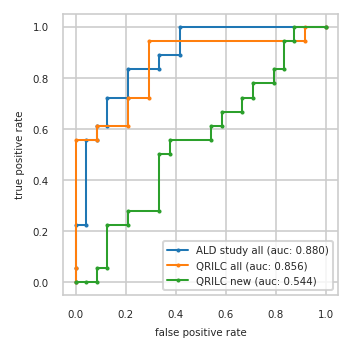

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.222     0.000 0.556     0.083 0.000
3          0.042 0.222     0.083 0.556     0.083 0.056
4          0.042 0.556     0.083 0.611     0.125 0.056
5          0.083 0.556     0.208 0.611     0.125 0.222
6          0.083 0.611     0.208 0.722     0.208 0.222
7          0.125 0.611     0.292 0.722     0.208 0.278
8          0.125 0.722     0.292 0.944     0.333 0.278
9          0.208 0.722     0.917 0.944     0.333 0.500
10         0.208 0.833     0.917 1.000     0.375 0.500
11         0.333 0.833     1.000 1.000     0.375 0.556
12         0.333 0.889       NaN   NaN     0.542 0.556
13         0.417 0.889       NaN   NaN     0.542 0.611
14         0.417 1.000       NaN   NaN     0.583 0.611
15         1.000 1.000       NaN   NaN     0.583 0.667
16           NaN   NaN       NaN   NaN     0.667 0.667
17           NaN   NaN       NaN   NaN     0.667 0.722
18           NaN   NaN       NaN   NaN     0.708 0.722
19           NaN   NaN       NaN   NaN     0.708 0.778
20           NaN   NaN       NaN   NaN     0.792 0.778
21           NaN   NaN       NaN   NaN     0.792 0.833
22           NaN   NaN       NaN   NaN     0.833 0.833
23           NaN   NaN       NaN   NaN     0.833 0.944
24           NaN   NaN       NaN   NaN     0.875 0.944
25           NaN   NaN       NaN   NaN     0.875 1.000
26           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...
1,P00740;P00740-2,Q8NFY4;Q8NFY4-6,None
2,Q9NR34,P01597;P04432,None
3,Q13231;Q13231-3,P61981,None
4,P04075,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...,None
5,C9JF17;P05090,Q9Y2T3;Q9Y2T3-3,None
6,None,E7EN89;E9PP67;E9PQ25;F2Z2Y8;Q9H0E2;Q9H0E2-2,None
7,None,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3,None
8,None,P04075,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


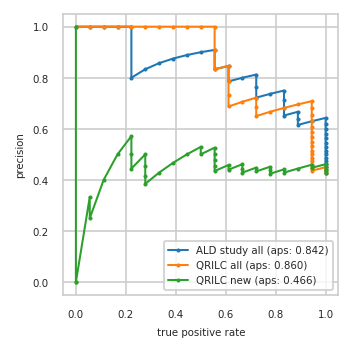

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.436 0.944     0.462 1.000
4          0.474 1.000     0.447 0.944     0.447 0.944
5          0.486 1.000     0.459 0.944     0.459 0.944
6          0.500 1.000     0.472 0.944     0.444 0.889
7          0.514 1.000     0.486 0.944     0.429 0.833
8          0.529 1.000     0.500 0.944     0.441 0.833
9          0.545 1.000     0.515 0.944     0.424 0.778
10         0.562 1.000     0.531 0.944     0.438 0.778
11         0.581 1.000     0.548 0.944     0.452 0.778
12         0.600 1.000     0.567 0.944     0.433 0.722
13         0.621 1.000     0.586 0.944     0.448 0.722
14         0.643 1.000     0.607 0.944     0.429 0.667
15         0.630 0.944     0.630 0.944     0.444 0.667
16         0.615 0.889     0.654 0.944     0.462 0.667
17         0.640 0.889     0.680 0.944     0.440 0.611
18         0.667 0.889     0.708 0.944     0.458 0.611
19         0.652 0.833     0.696 0.889     0.435 0.556
20         0.682 0.833     0.682 0.833     0.455 0.556
21         0.714 0.833     0.667 0.778     0.476 0.556
22         0.750 0.833     0.650 0.722     0.500 0.556
23         0.737 0.778     0.684 0.722     0.526 0.556
24         0.722 0.722     0.722 0.722     0.500 0.500
25         0.765 0.722     0.706 0.667     0.529 0.500
26         0.812 0.722     0.688 0.611     0.500 0.444
27         0.800 0.667     0.733 0.611     0.467 0.389
28         0.786 0.611     0.786 0.611     0.429 0.333
29         0.846 0.611     0.846 0.611     0.385 0.278
30         0.833 0.556     0.833 0.556     0.417 0.278
31         0.909 0.556     0.909 0.556     0.455 0.278
32         0.900 0.500     1.000 0.556     0.500 0.278
33         0.889 0.444     1.000 0.500     0.444 0.222
34         0.875 0.389     1.000 0.444     0.500 0.222
35         0.857 0.333     1.000 0.389     0.571 0.222
36         0.833 0.278     1.000 0.333     0.500 0.167
37         0.800 0.222     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


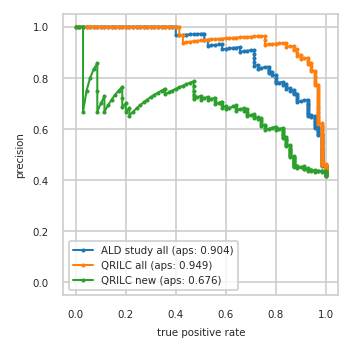

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


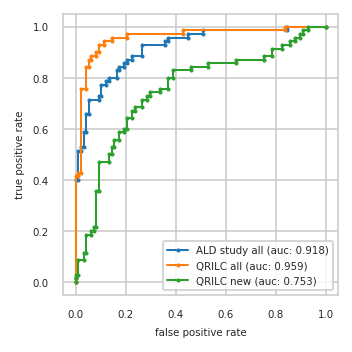

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}